In [24]:
pip install relativeImp

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\env\matrixenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [25]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns

from relativeImp import relativeImp

In [12]:
#SETTINGS
sns.set(rc={'figure.figsize':(20,20)})

In [13]:
#READ DATA
sample_data = pd.read_excel('data\SAMPLE_DATA.xlsx', header = 1)

In [14]:
#EXTRACT EXPLANATION 
explantion = sample_data['Variables']
sample_data = sample_data.drop(['Variables'], axis=1)

In [15]:
#TRANSPOSE DATA
transpose_sample_data = sample_data.T

In [18]:
#ADD HEADER
main_data = transpose_sample_data.rename(columns=transpose_sample_data.iloc[0]).drop(transpose_sample_data.index[0])

In [19]:
main_df = main_data.astype(float)

In [20]:
main_df.head(5)

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,BRAND_A_OTHER_CATEGORY_1_GRP,BRAND_A_OTHER_CATEGORY_2_GRP,COMPETITOR_B_TOTAL_GRP,COMPETITOR_C_TOTAL_GRP,COMPETITOR_D_TOTAL_GRP,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A
2016-05-02 00:00:00,35232.8,12.593379,11.89,15.37,13.35,11.74,0.0,0.0,0.0,0.0,...,0.0,72.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0
2016-05-09 00:00:00,155680.4,9.306888,9.51,9.65,9.94,8.36,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0
2016-05-16 00:00:00,34356.6,12.539075,12.14,15.17,13.04,11.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0
2016-05-23 00:00:00,34145.7,12.915243,12.69,15.61,13.49,11.61,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0
2016-05-30 00:00:00,35328.5,12.678149,12.31,15.47,13.67,12.17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0


### Correlation HeatMap

In [21]:
corr = main_df.corr()

<AxesSubplot:>

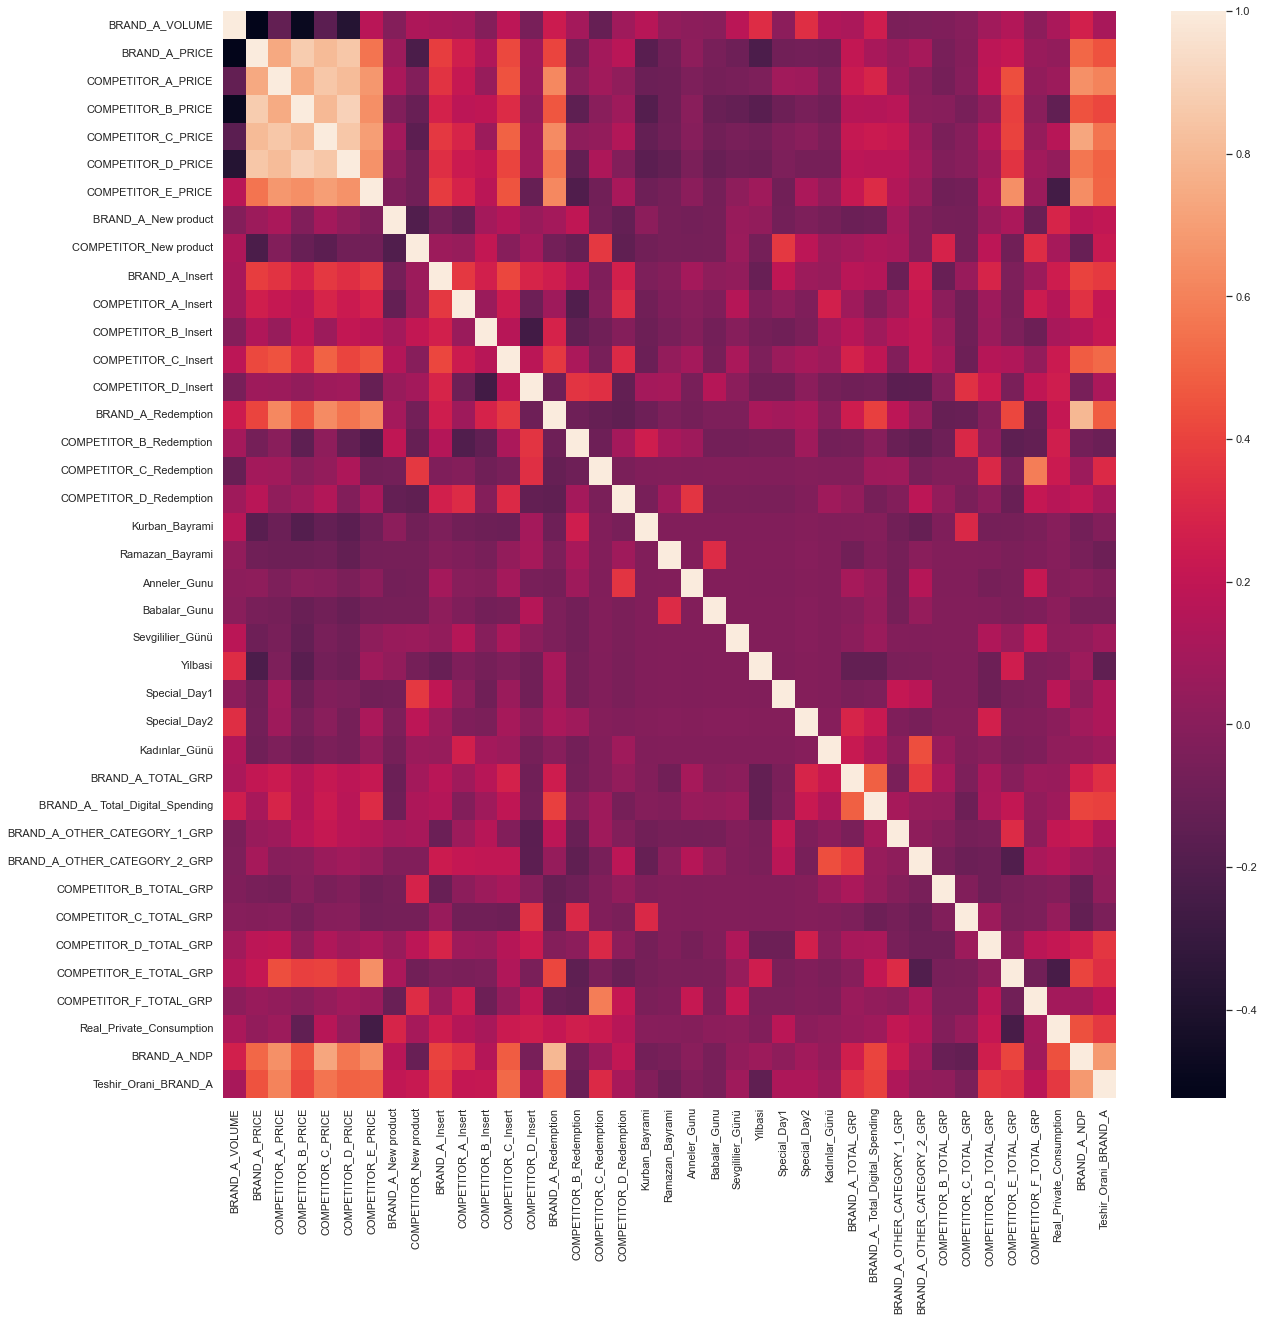

In [22]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Key-Driver Analysis

Relative importance or relative weight analysis is a method to “partition explained variance among multiple predictors to better understand the role played by each predictor in a regression equation” [(Tonidandel & LeBreton, 2011)](https://www.scotttonidandel.com/rwa-web). 

In [26]:
yName =  'BRAND_A_VOLUME'

xNames = ['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE', 'COMPETITOR_E_PRICE',
       'BRAND_A_New product', 'COMPETITOR_New product', 'BRAND_A_Insert',
       'COMPETITOR_A_Insert', 'COMPETITOR_B_Insert',
       'COMPETITOR_C_Insert', 'COMPETITOR_D_Insert', 'BRAND_A_Redemption',
       'COMPETITOR_B_Redemption', 'COMPETITOR_C_Redemption',
       'COMPETITOR_D_Redemption', 'Kurban_Bayrami', 'Ramazan_Bayrami',
       'Anneler_Gunu', 'Babalar_Gunu', 'Sevgililier_Günü', 'Yilbasi',
       'Special_Day1', 'Special_Day2', 'Kadınlar_Günü',
       'BRAND_A_TOTAL_GRP', 'BRAND_A_ Total_Digital_Spending',
       'BRAND_A_OTHER_CATEGORY_1_GRP', 'BRAND_A_OTHER_CATEGORY_2_GRP',
       'COMPETITOR_B_TOTAL_GRP', 'COMPETITOR_C_TOTAL_GRP',
       'COMPETITOR_D_TOTAL_GRP', 'COMPETITOR_E_TOTAL_GRP',
       'COMPETITOR_F_TOTAL_GRP', 'Real_Private_Consumption',
       'BRAND_A_NDP', 'Teshir_Orani_BRAND_A']

results = relativeImp(main_df, outcomeName = yName, driverNames = xNames)
results.sort_values(by=['rawRelaImpt','normRelaImpt'],ascending=False)

,driver,rawRelaImpt,normRelaImpt
0,BRAND_A_PRICE,0.151319,17.055119
2,COMPETITOR_B_PRICE,0.116164,13.092788
4,COMPETITOR_D_PRICE,0.076695,8.644255
3,COMPETITOR_C_PRICE,0.049528,5.582263
13,BRAND_A_Redemption,0.049301,5.556718
36,BRAND_A_NDP,0.047541,5.358399
22,Yilbasi,0.047528,5.356926
24,Special_Day2,0.044598,5.026588
5,COMPETITOR_E_PRICE,0.041939,4.726898
1,COMPETITOR_A_PRICE,0.039838,4.490113


In [ ]:
sum(results.rawRelaImpt) # R-squared

# What is a good R-squared?
# <.3 is not good
# .3 - .4 is normal
# .4 - .5 is great
# .5 - .6 is exceptional
# >.6 is dangerously high, possibly overfitting